## Grocery Sales Forcesting
## The aim of this project is to forecast more accurate product sales for the Ecuadorian supermarket chain based on certain features.

The data comes in the shape of multiple files. First, the training data (train.csv) essentially contains the sales by date, store, and item. The test data (test.csv) contains the same features without the sales information, which we are tasked to predict. The train vs test split is based on the date. In addition, some test items are not included in the train data

In [1]:
#Loading all the relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder,minmax_scale,PolynomialFeatures,StandardScaler,Normalizer
from sklearn.model_selection import KFold,GridSearchCV,train_test_split
import matplotlib.pyplot as plt
from scipy.stats import itemfreq
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
#from sklearn.model_selection import train_test_split
%matplotlib inline
import datetime
from datetime import date, timedelta
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import keras
import sys
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
import lightgbm as lgb

Using TensorFlow backend.


There are 5 additional data files that provide the following information:

-- stores.csv : Details about the stores, such as location and type.

-- items.csv: Item metadata, such as class and whether they are perishable. Note, that perishable items have a higher scoring weight than others.

-- transactions.csv: Count of sales transactions for the training data

-- oil.csv: Daily oil price. This is relevant, because “Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices.” (source)

-- holidays_events.csv: Holidays in Ecuador. Some holidays can be transferred to another day (possibly from weekend to weekday).


<img src="Capture1.jpg">


In [2]:
#Loading the data
dtypes = {'store_nbr': np.dtype('int64'),
          'item_nbr': np.dtype('int64'),
          'unit_sales': np.dtype('float64'),
          'onpromotion': np.dtype('O')}

Sales = pd.read_csv('favoritaTrain_Set2.csv', dtype=dtypes)
test = pd.read_csv('test.csv', dtype=dtypes)
stores = pd.read_csv('stores.csv')
items = pd.read_csv('items.csv')
trans = pd.read_csv('transactions.csv')
#oil = pd.read_csv('../input/oil.csv') #we upload this database later
holidays = pd.read_csv('holidays_events.csv')

In [3]:
#sampling the data, since the data is too huge to carry put any operations
date_mask = (Sales['date'] >= '2017-07-15') & (Sales['date'] <= '2017-08-15')

Salesdf = Sales[date_mask]

#Print the size
len(Salesdf)

336867

In [4]:
#Load the data
oil = pd.read_csv('oil.csv')

#add missing date
min_oil_date = min(Salesdf.date)
max_oil_date = max(Salesdf.date)

calendar = []

d1 = datetime.datetime.strptime(min_oil_date, '%Y-%m-%d')  # start date
d2 = datetime.datetime.strptime(max_oil_date, '%Y-%m-%d')  # end date

delta = d2 - d1         # timedelta

for i in range(delta.days + 1):
    calendar.append(datetime.date.strftime(d1 + timedelta(days=i), '%Y-%m-%d'))

calendar = pd.DataFrame({'date':calendar})

oil = calendar.merge(oil, left_on='date', right_on='date', how='left')

In [5]:
oil.head()

,date,dcoilwtico
0,2017-07-15,NaN
1,2017-07-16,NaN
2,2017-07-17,46.02
3,2017-07-18,46.40
4,2017-07-19,47.10


In [6]:
#Check how many NA
print(oil.isnull().sum(), '\n')

#Type
print('Type : ', '\n', oil.dtypes)

#Print the 3 first line
oil.head(5)

date           0
dcoilwtico    10
dtype: int64 

Type :  
 date           object
dcoilwtico    float64
dtype: object


,date,dcoilwtico
0,2017-07-15,NaN
1,2017-07-16,NaN
2,2017-07-17,46.02
3,2017-07-18,46.40
4,2017-07-19,47.10


In [7]:
#Check index to apply the formula
na_index_oil = oil[oil['dcoilwtico'].isnull() == True].index.values

#Define the index to use to apply the formala
na_index_oil_plus = na_index_oil.copy()
na_index_oil_minus = np.maximum(0, na_index_oil-1)

for i in range(len(na_index_oil)):
    k = 1
    while (na_index_oil[min(i+k,len(na_index_oil)-1)] == na_index_oil[i]+k):
        k += 1
    na_index_oil_plus[i] = min(len(oil)-1, na_index_oil_plus[i] + k )

#Apply the formula
for i in range(len(na_index_oil)):
    if (na_index_oil[i] == 0):
        oil.loc[na_index_oil[i], 'dcoilwtico'] = oil.loc[na_index_oil_plus[i], 'dcoilwtico']
    elif (na_index_oil[i] == len(oil)):
        oil.loc[na_index_oil[i], 'dcoilwtico'] = oil.loc[na_index_oil_minus[i], 'dcoilwtico']
    else:
        oil.loc[na_index_oil[i], 'dcoilwtico'] = (oil.loc[na_index_oil_plus[i], 'dcoilwtico'] + oil.loc[na_index_oil_minus[i], 'dcoilwtico'])/ 2   

In [8]:
oil.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

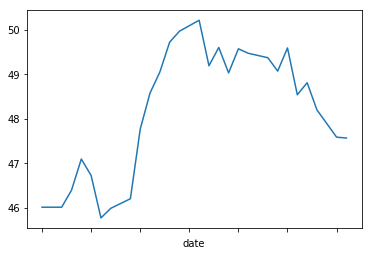

In [9]:
#Plot the oil values
oil_plot = oil['dcoilwtico'].copy()
oil_plot.index = oil['date'].copy()
oil_plot.plot()
plt.show()

In [10]:
#Merge train
Salesdf = Salesdf.drop('id', axis = 1)
Salesdf = Salesdf.merge(stores, left_on='store_nbr', right_on='store_nbr', how='left')
Salesdf = Salesdf.merge(items, left_on='item_nbr', right_on='item_nbr', how='left')
Salesdf = Salesdf.merge(holidays, left_on='date', right_on='date', how='left')
Salesdf = Salesdf.merge(oil, left_on='date', right_on='date', how='left')
Salesdf = Salesdf.drop(['description', 'state', 'locale_name', 'class'], axis = 1)

In [11]:
Salesdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336867 entries, 0 to 336866
Data columns (total 14 columns):
date           336867 non-null object
store_nbr      336867 non-null int64
item_nbr       336867 non-null int64
unit_sales     336867 non-null float64
onpromotion    336867 non-null object
city           336867 non-null object
type_x         336867 non-null object
cluster        336867 non-null int64
family         336867 non-null object
perishable     336867 non-null int64
type_y         73283 non-null object
locale         73283 non-null object
transferred    73283 non-null object
dcoilwtico     336867 non-null float64
dtypes: float64(2), int64(4), object(8)
memory usage: 38.6+ MB


In [12]:
Salesdf.isnull().sum().sort_values(ascending=False)

transferred    263584
locale         263584
type_y         263584
dcoilwtico          0
perishable          0
family              0
cluster             0
type_x              0
city                0
onpromotion         0
unit_sales          0
item_nbr            0
store_nbr           0
date                0
dtype: int64

In [13]:
#Shape
print('Shape : ', Salesdf.shape, '\n')

#Type
print('Type : ', '\n', Salesdf.dtypes)

#Summary
Salesdf.describe()

Shape :  (336867, 14) 

Type :  
 date            object
store_nbr        int64
item_nbr         int64
unit_sales     float64
onpromotion     object
city            object
type_x          object
cluster          int64
family          object
perishable       int64
type_y          object
locale          object
transferred     object
dcoilwtico     float64
dtype: object


,store_nbr,item_nbr,unit_sales,cluster,perishable,dcoilwtico
count,336867.000000,3.368670e+05,336867.000000,336867.000000,336867.000000,336867.000000
mean,28.313305,1.170498e+06,8.043790,8.709102,0.258402,48.146043
std,16.309769,5.868558e+05,22.929827,4.563188,0.437757,1.467865
min,1.000000,9.699500e+04,-36.000000,1.000000,0.000000,45.780000
25%,13.000000,6.925310e+05,2.000000,5.000000,0.000000,46.400000
50%,29.000000,1.209720e+06,4.000000,9.000000,0.000000,48.580000
75%,44.000000,1.576330e+06,8.000000,13.000000,1.000000,49.470000
max,54.000000,2.127114e+06,3952.000000,17.000000,1.000000,50.210000


In [14]:
#5 random lines
Salesdf.sample(10)

,date,store_nbr,item_nbr,unit_sales,onpromotion,city,type_x,cluster,family,perishable,type_y,locale,transferred,dcoilwtico
263702,2017-07-15,27,1976260,8.0,False,Daule,D,1,BEVERAGES,0,NaN,NaN,NaN,46.020
14933,2017-08-15,29,1464088,15.0,True,Guayaquil,E,10,BEVERAGES,0,Holiday,Local,False,47.570
143912,2017-07-25,10,364829,3.0,False,Quito,C,15,GROCERY I,0,Additional,Local,False,47.770
166858,2017-07-31,47,105693,2.0,False,Quito,A,14,GROCERY I,0,NaN,NaN,NaN,50.210
131519,2017-08-13,47,414750,91.0,False,Quito,A,14,GROCERY I,0,NaN,NaN,NaN,47.895
103282,2017-08-06,42,1457001,1.0,False,Cuenca,D,2,HOME CARE,0,NaN,NaN,NaN,49.420
233389,2017-07-27,17,472658,5.0,False,Quito,C,12,GROCERY I,0,NaN,NaN,NaN,49.050
163440,2017-08-05,42,1457175,3.0,False,Cuenca,D,2,HOME CARE,0,Holiday,Local,False,49.470
51583,2017-08-03,2,468265,6.0,False,Quito,D,13,BEVERAGES,0,NaN,NaN,NaN,49.030
31581,2017-07-22,19,1047775,5.0,False,Guaranda,C,15,BEVERAGES,0,NaN,NaN,NaN,45.995


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


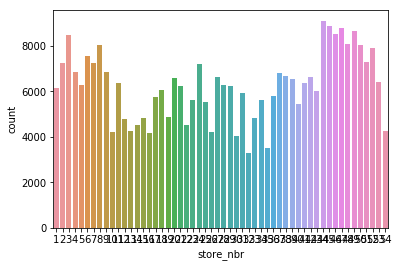

In [15]:
sns.countplot(x='store_nbr', data=Salesdf);

In [16]:
Salesdf.item_nbr.unique

<bound method Series.unique of 0          633977
1         1991151
2          968935
3         1909453
4         1695875
5          884878
6          322095
7          915980
8          939131
9         2013621
10         838216
11        1146783
12        1473428
13         940590
14         938126
15        2027777
16         916886
17        1660194
18         404334
19         214381
20        1114761
21         414426
22        2035581
23         513855
24        2010766
25        1473511
26        1112840
27        1037857
28         769312
29         510054
           ...   
336837    1987383
336838     273528
336839     315320
336840    1473476
336841    1321497
336842     872317
336843    1456881
336844    1967038
336845     552050
336846    1695848
336847     839362
336848     979197
336849     360705
336850    1920284
336851    1464088
336852    1281011
336853     957096
336854    1914786
336855    1153584
336856     812751
336857    1986680
336858    2048358
336859    11503

In [17]:
x=itemfreq(Salesdf.item_nbr)
x=x[x[:,1].argsort()[::-1]]
x

array([[1254013,     203],
       [2042947,     195],
       [ 847863,     190],
       ..., 
       [1047709,       1],
       [2011032,       1],
       [1360013,       1]], dtype=int64)

In [18]:
x[:,0][0:10]

array([1254013, 2042947,  847863, 1473475, 1489899,  115894,  273528,
       1342003, 1157329, 1080021], dtype=int64)

In [19]:
s=Salesdf.item_nbr.as_matrix()
s

array([ 633977, 1991151,  968935, ..., 1456916, 1471462,  671079], dtype=int64)

In [20]:
t=s.reshape(s.shape[0],1)
t

array([[ 633977],
       [1991151],
       [ 968935],
       ..., 
       [1456916],
       [1471462],
       [ 671079]], dtype=int64)

In [21]:
t1=np.where(t==x)
t1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


(array([], dtype=int64),)

## Fetching the N most purchased products

In [22]:
#Fetching the N most purchased products#
def N_most_labels(data, variable , N , all='TRUE'):
    labels_freq_pd = itemfreq(data[variable])
    labels_freq_pd = labels_freq_pd[labels_freq_pd[:, 1].argsort()[::-1]] #[::-1] ==> to sort in descending order
    
    if all == 'FALSE':
        main_labels = labels_freq_pd[:,0][0:N]
    else: 
        main_labels = labels_freq_pd[:,0][:]
        
    labels_raw_np = data[variable].as_matrix() #transform in numpy
    labels_raw_np = labels_raw_np.reshape(labels_raw_np.shape[0],1)

    labels_filtered_index = np.where(labels_raw_np == main_labels)
    
    return labels_freq_pd, labels_filtered_index

label_freq, labels_filtered_index = N_most_labels(data = Salesdf, variable = "item_nbr", N = 20, all='FALSE')
print("labels_filtered_index[0].shape = ", labels_filtered_index[0].shape)

Salesdf_filtered = Salesdf.loc[labels_filtered_index[0],:]


labels_filtered_index[0].shape =  (3735,)


In [23]:
label_freq[0:10]

array([[1254013,     203],
       [2042947,     195],
       [ 847863,     190],
       [1473475,     189],
       [1489899,     189],
       [ 115894,     188],
       [ 273528,     187],
       [1342003,     186],
       [1157329,     186],
       [1080021,     186]], dtype=int64)

In [24]:
Salesdf_filtered.sample(3)

,date,store_nbr,item_nbr,unit_sales,onpromotion,city,type_x,cluster,family,perishable,type_y,locale,transferred,dcoilwtico
90560,2017-08-01,6,1958181,8.0,False,Quito,D,13,BEVERAGES,0,NaN,NaN,NaN,49.19
220061,2017-08-09,30,165988,2.0,False,Guayaquil,C,3,GROCERY I,0,NaN,NaN,NaN,49.59
57321,2017-07-28,33,1958181,3.0,False,Quevedo,C,3,BEVERAGES,0,NaN,NaN,NaN,49.72


In [25]:
#Fill in cells if there is no holiday by the value : "no_holyday"
na_index_Salesdf = Salesdf_filtered[Salesdf_filtered['type_y'].isnull() == True].index.values
print("Size of na_index_Salesdf : ", len(na_index_Salesdf), '\n')

Salesdf_filtered.loc[Salesdf_filtered['type_y'].isnull(), 'type_y'] = "no_holyday"
Salesdf_filtered.loc[Salesdf_filtered['locale'].isnull(), 'locale'] = "no_locale"
Salesdf_filtered.loc[Salesdf_filtered['transferred'].isnull(), 'transferred'] = "no_holyday"
    
#check is there is NA
Salesdf_filtered.isnull().sum()

Size of na_index_Salesdf :  2933 



date           0
store_nbr      0
item_nbr       0
unit_sales     0
onpromotion    0
city           0
type_x         0
cluster        0
family         0
perishable     0
type_y         0
locale         0
transferred    0
dcoilwtico     0
dtype: int64

In [26]:
def get_month_year(df):
    df['month'] = df.date.apply(lambda x: x.split('-')[1])
    df['year'] = df.date.apply(lambda x: x.split('-')[0])
    
    return df

get_month_year(Salesdf_filtered);

In [27]:
Salesdf_filtered['date'] = pd.to_datetime(Salesdf_filtered['date'])
Salesdf_filtered['day'] = Salesdf_filtered['date'].dt.weekday_name
Salesdf_filtered = Salesdf_filtered.drop('date', axis=1)

In [28]:
Salesdf_filtered.sample(10)

,store_nbr,item_nbr,unit_sales,onpromotion,city,type_x,cluster,family,perishable,type_y,locale,transferred,dcoilwtico,month,year,day
332478,45,847863,19.0,True,Quito,A,11,GROCERY I,0,no_holyday,no_locale,no_holyday,47.895,08,2017,Sunday
240001,2,315474,3.0,False,Quito,D,13,BREAD/BAKERY,1,no_holyday,no_locale,no_holyday,49.190,08,2017,Tuesday
220061,30,165988,2.0,False,Guayaquil,C,3,GROCERY I,0,no_holyday,no_locale,no_holyday,49.590,08,2017,Wednesday
102919,39,1254013,11.0,False,Cuenca,B,6,PERSONAL CARE,0,no_holyday,no_locale,no_holyday,47.590,08,2017,Monday
59474,5,1087269,5.0,False,Santo Domingo,D,4,PERSONAL CARE,0,no_holyday,no_locale,no_holyday,46.400,07,2017,Tuesday
295891,12,1418845,13.0,False,Latacunga,C,15,GROCERY I,0,Holiday,Local,False,49.470,08,2017,Saturday
210059,36,2042941,46.0,False,Libertad,E,10,BEVERAGES,0,Holiday,Local,False,47.570,08,2017,Tuesday
3256,28,273528,21.0,False,Guayaquil,E,10,PERSONAL CARE,0,no_holyday,no_locale,no_holyday,46.020,07,2017,Saturday
179643,3,315474,10.0,False,Quito,D,8,BREAD/BAKERY,1,no_holyday,no_locale,no_holyday,49.190,08,2017,Tuesday
201964,17,1342003,14.0,False,Quito,C,12,GROCERY I,0,no_holyday,no_locale,no_holyday,49.420,08,2017,Sunday


In [29]:
strain = Salesdf.sample(frac=0.01,replace=True)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


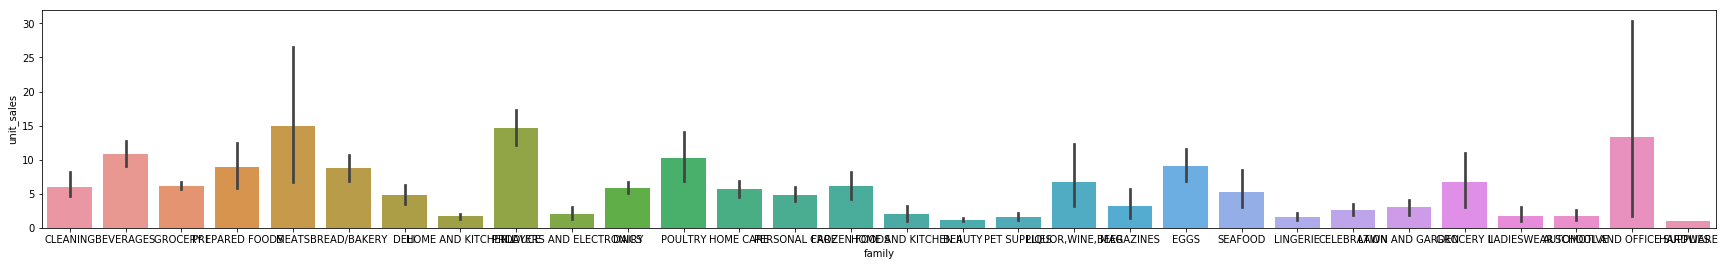

In [30]:
# Plotting Sales per Item Family
fig, (axis1) = plt.subplots(1,1,figsize=(30,4))
sns.barplot(x='family', y='unit_sales', data=strain, ax=axis1)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


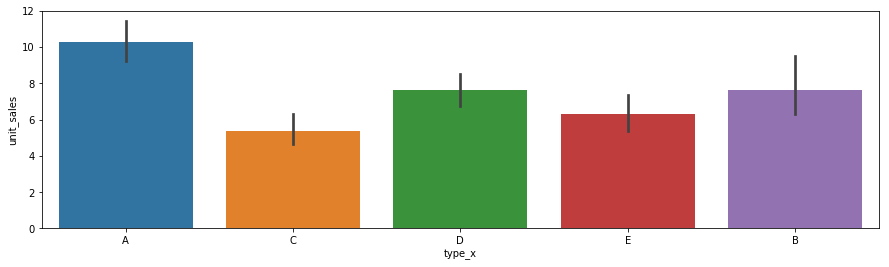

In [31]:
# Plotting Sales per Store Type
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.barplot(x='type_x', y='unit_sales', data=strain, ax=axis1)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


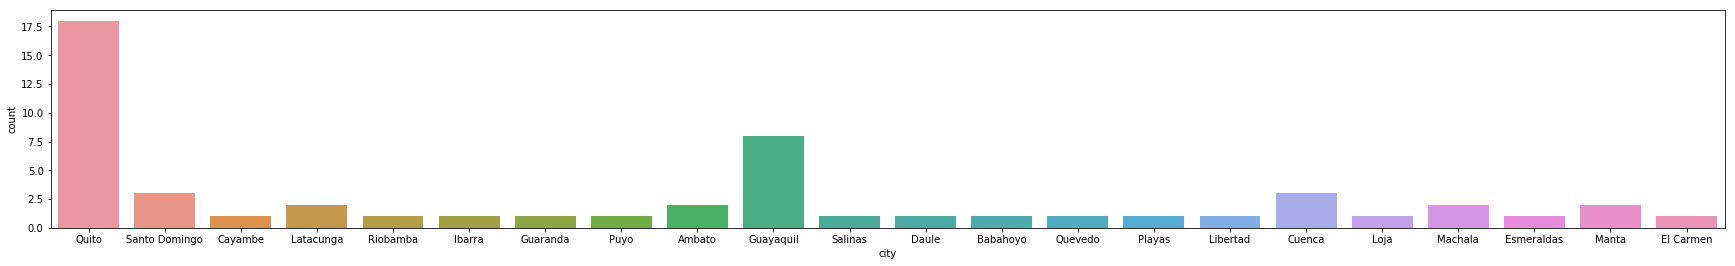

In [32]:
# Plotting Stores in Cities
fig, (axis1) = plt.subplots(1,1,figsize=(30,4))
sns.countplot(x=stores['city'], data=stores, ax=axis1)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


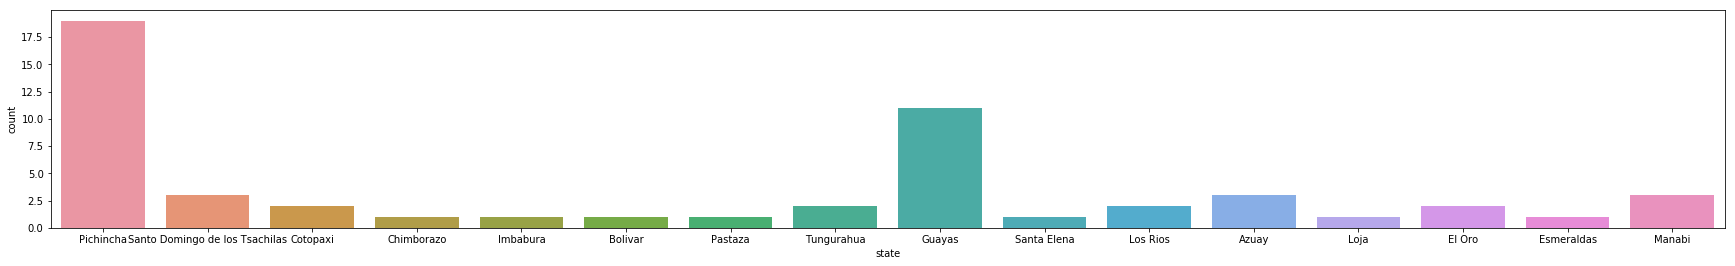

In [33]:
# Plotting Stores in States
fig, (axis1) = plt.subplots(1,1,figsize=(30,4))
sns.countplot(x=stores['state'], data=stores, ax=axis1)

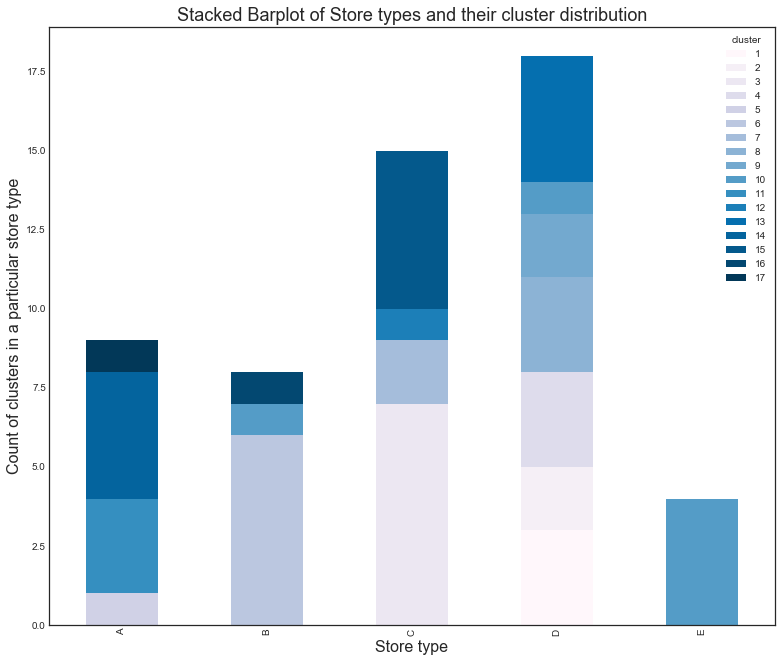

In [34]:
# Stacked Barplots of Types against clusters
plt.style.use('seaborn-white')
#plt.style.use('dark_background')
type_cluster = stores.groupby(['type','cluster']).size()
type_cluster.unstack().plot(kind='bar',stacked=True, colormap= 'PuBu', figsize=(13,11),  grid=False)
plt.title('Stacked Barplot of Store types and their cluster distribution', fontsize=18)
plt.ylabel('Count of clusters in a particular store type', fontsize=16)
plt.xlabel('Store type', fontsize=16)
plt.show()

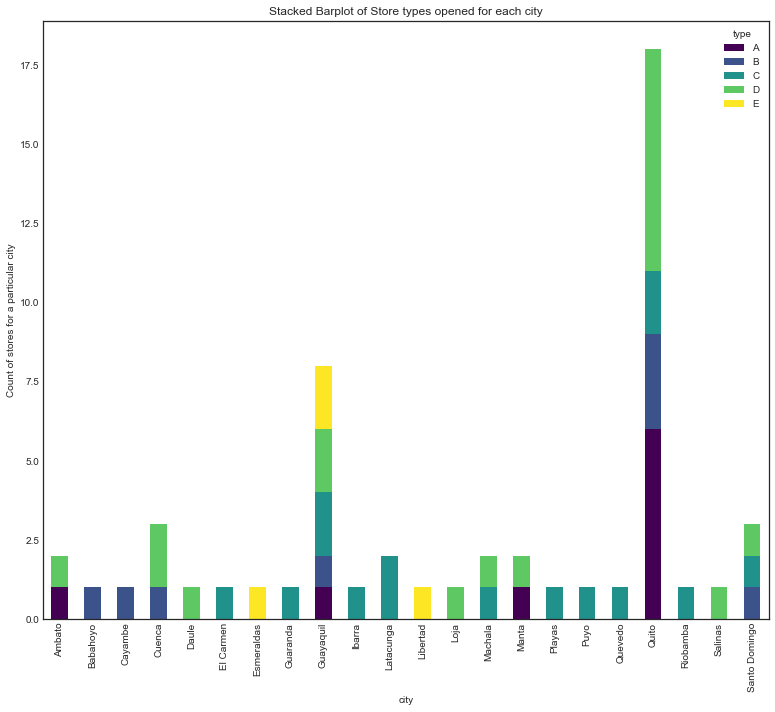

In [35]:
# Stacked barplot of types of stores across the different cities
plt.style.use('seaborn-white')
city_cluster = stores.groupby(['city','type']).store_nbr.size()
city_cluster.unstack().plot(kind='bar',stacked=True, colormap= 'viridis', figsize=(13,11),  grid=False)
plt.title('Stacked Barplot of Store types opened for each city')
plt.ylabel('Count of stores for a particular city')
plt.show()

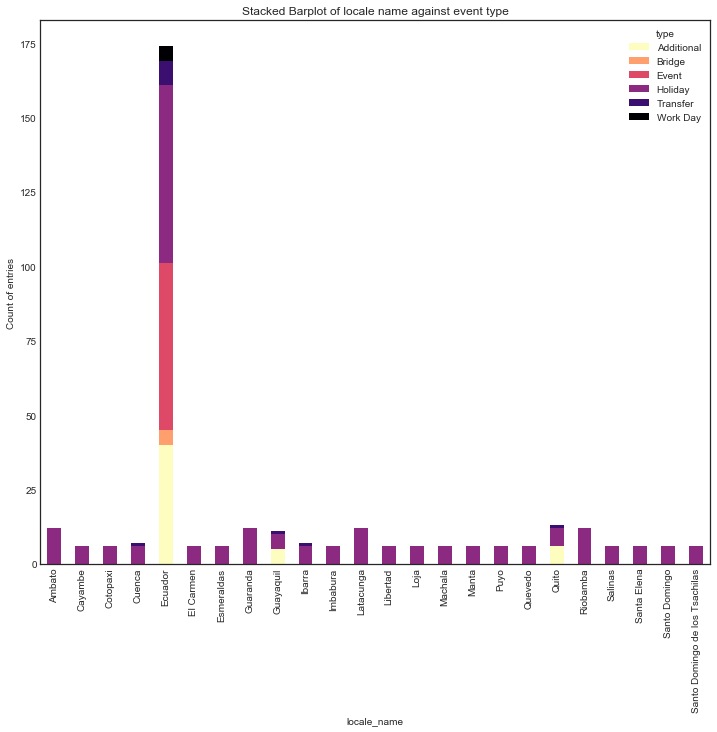

In [36]:
# Holiday Events data
plt.style.use('seaborn-white')
# plt.style.use('dark_background')
holiday_local_type = holidays.groupby(['locale_name', 'type']).size()
holiday_local_type.unstack().plot(kind='bar',stacked=True, colormap= 'magma_r', figsize=(12,10),  grid=False)
plt.title('Stacked Barplot of locale name against event type')
plt.ylabel('Count of entries')
plt.show()

## What is One Hot Encoding?
A one hot encoding is a representation of categorical variables as binary vectors.
This first requires that the categorical values be mapped to integer values.
Then, each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a 1.

## Why Use a One Hot Encoding?
A one hot encoding allows the representation of categorical data to be more expressive.
Many machine learning algorithms cannot work with categorical data directly. The categories must be converted into numbers. This is required for both input and output variables that are categorical.



In [37]:
## One hot encoding using get_dummies on pandas dataframe.
dummy_variables = ['onpromotion','city','type_x','cluster','store_nbr','item_nbr',
                'family','perishable','type_y', 'locale', 'transferred', 'month', 'day']

for var in dummy_variables:
    dummy = pd.get_dummies(Salesdf_filtered[var], prefix = var, drop_first = False)
    Salesdf_filtered = pd.concat([Salesdf_filtered, dummy], axis = 1)

Salesdf_filtered = Salesdf_filtered.drop(dummy_variables, axis = 1)
Salesdf_filtered = Salesdf_filtered.drop(['year'], axis = 1)

In [38]:
Salesdf_filtered.info()
#Salesdf_filtered.sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3735 entries, 135 to 336838
Columns: 149 entries, unit_sales to day_Wednesday
dtypes: float64(2), uint8(147)
memory usage: 623.7 KB


In [39]:
Salesdf_filtered.head()

,unit_sales,dcoilwtico,onpromotion_False,onpromotion_True,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,...,transferred_no_holyday,month_07,month_08,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
135,27.0,49.5900,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1
183,18.0,50.0875,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,0
339,31.0,46.1025,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
396,7.0,45.9950,1,0,0,0,0,1,0,0,...,1,1,0,0,0,1,0,0,0,0
423,24.0,48.2000,1,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0


In [40]:
#Re-scale
#We keep this value to re-scale the predicted unit_sales values in the following lines of code.
min_train, max_train = Salesdf_filtered['unit_sales'].min(), Salesdf_filtered['unit_sales'].max()

In [41]:
scalable_variables = ['unit_sales','dcoilwtico']

for var in scalable_variables:
    mini, maxi = Salesdf_filtered[var].min(), Salesdf_filtered[var].max()
    Salesdf_filtered.loc[:,var] = (Salesdf_filtered[var] - mini) / (maxi - mini)

In [42]:
print('Shape : ', Salesdf_filtered.shape)
Salesdf_filtered.sample(10)

Shape :  (3735, 149)


,unit_sales,dcoilwtico,onpromotion_False,onpromotion_True,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,...,transferred_no_holyday,month_07,month_08,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
316791,0.015300,0.632054,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1
48765,0.004188,0.214447,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,0,0
270693,0.005422,1.000000,1,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0
196282,0.020239,0.404063,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
201523,0.012213,0.214447,0,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,0,0
316148,0.006657,0.742664,1,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,0,1,0
241288,0.006040,0.683973,1,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
120316,0.001718,1.000000,1,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0
176601,0.007892,0.139955,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
299157,0.002335,0.860045,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1


In [44]:
Salesdf_filtered.isnull().sum()


unit_sales                0
dcoilwtico                0
onpromotion_False         0
onpromotion_True          0
city_Ambato               0
city_Babahoyo             0
city_Cayambe              0
city_Cuenca               0
city_Daule                0
city_El Carmen            0
city_Esmeraldas           0
city_Guaranda             0
city_Guayaquil            0
city_Ibarra               0
city_Latacunga            0
city_Libertad             0
city_Loja                 0
city_Machala              0
city_Manta                0
city_Playas               0
city_Puyo                 0
city_Quevedo              0
city_Quito                0
city_Riobamba             0
city_Salinas              0
city_Santo Domingo        0
type_x_A                  0
type_x_B                  0
type_x_C                  0
type_x_D                  0
                         ..
item_nbr_1958181          0
item_nbr_2042941          0
item_nbr_2042947          0
family_BEVERAGES          0
family_BREAD/BAKERY 

In [45]:
#train database without unit_sales
Salesdf_filtered = Salesdf_filtered.reset_index(drop=True)  #we reset the index
y = Salesdf_filtered['unit_sales']
X = Salesdf_filtered.drop(['unit_sales'], axis = 1)

print('Shape X :', X.shape)
print('Shape y :', y.shape)

Shape X : (3735, 148)
Shape y : (3735,)


In [46]:
num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test, random_state=15)
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

X_train shape : (2988, 148)
y_train shape : (2988,)
X_test shape : (747, 148)
y_test shape : (747,)


## Linear Regression

Linear Regression is a linear approach for modelling the relationship between a scalar dependent variable y and one or more explanatory variables (or independent variables) denoted X. The case of one explanatory variable is called simple linear regression. For more than one explanatory variable, the process is called multiple linear regression.

Linear regression models are often fitted using the least squares approach, but they may also be fitted in other ways, such as by minimizing the "lack of fit" in some other norm (as with least absolute deviations regression), or by minimizing a penalized version of the least squares cost function as in ridge regression (L2-norm penalty) and lasso (L1-norm penalty). 

In [47]:
# Fit the linear model
model = linear_model.LinearRegression()
results = model.fit(X_train, y_train)
print(results)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


In [48]:
# Print the coefficients
print (results.intercept_, results.coef_)

-10077717828.6 [  5.77278827e-03  -4.44002834e+11  -4.44002834e+11  -1.20049145e+11
   6.71849673e+11  -3.00197319e+11  -4.10525006e+11  -2.19780004e+11
  -3.50107920e+11  -8.38620072e+10  -1.07196630e+11  -6.50316918e+10
   9.76924707e+10   1.79310313e+11  -3.68439881e+11   3.24373052e+11
   6.87498201e+10  -1.73268895e+11   5.88248972e+10   1.63766182e+11
   1.05804503e+11  -3.17490270e+10  -4.24909495e+11  -5.72211037e+11
  -1.78411474e+10  -1.05642561e+11  -3.35504730e+11   5.95024592e+10
   1.64092747e+11  -4.61227293e+10  -1.03174077e+11   2.64559275e+11
  -4.43826214e+10  -3.55476150e+11   1.51662781e+11   1.59024917e+11
   1.51153503e+11  -3.34901373e+11  -2.07913878e+11   1.43898354e+11
  -1.15761973e+11   2.48465599e+10  -2.17076115e+11  -1.58991247e+11
  -3.25466957e+11   5.84658769e+10  -2.52456020e+10  -1.08276286e+11
  -1.08276286e+11   9.54897184e+09  -1.17438523e+11   1.62158689e+10
  -1.08276286e+11   9.54897184e+09   9.54897184e+09   1.52201578e+10
   1.04704843e+11  

In [49]:
import statsmodels.api as sm
import statsmodels.formula.api as sm
model = sm.OLS(y_train, X_train)
results = model.fit()
# Statsmodels gives R-like statistical output
results.summary()
# Here the Ordinalry Least Squares method has given us the r^2 value of 0.354 which is poor for model to be predicted on these variables.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             unit_sales   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     18.69
Date:                Fri, 20 Apr 2018   Prob (F-statistic):          2.22e-213
Time:                        23:23:17   Log-Likelihood:                 6716.8
No. Observations:                2988   AIC:                        -1.326e+04
Df Residuals:                    2902   BIC:                        -1.275e+04
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
dcoilwtico                 0.0057      0.002      3.394      0.001       0.002       0.009
onpromotion_False         -0.0037      0.001     -5.395      0.000      -0.005      -0.002
onpromotion_True           0.0082      0.001      9.787      0.000       0.007       0.010
city_Ambato               -0.0014      0.002     -0.839      0.401      -0.005       0.002
city_Babahoyo              0.0022      0.001      1.594      0.111      -0.000       0.005
city_Cayambe               0.0024      0.002      1.401      0.161      -0.001       0.006
city_Cuenca                0.0013      0.001      0.887      0.375      -0.002       0.004
city_Daule                -0.0002      0.002     -0.137      0.891      -0.003       0.003
city_El Carmen            -0.0013      0.002     -0.692      0.489      -0.005       0.002
city_Esmeraldas         -1.01e-05      0.002     -0.006      0.995      -0.003       0.003
city_Guaranda              0.0002      0.002      0.154      0.878      -0.003       0.003
city_Guayaquil          2.858e-05      0.001      0.024      0.981      -0.002       0.002
city_Ibarra               -0.0008      0.001     -0.533      0.594      -0.004       0.002
city_Latacunga         -4.487e-06      0.002     -0.003      0.998      -0.003       0.003
city_Libertad           6.975e-05      0.002      0.040      0.968      -0.003       0.004
city_Loja                  0.0010      0.002      0.575      0.565      -0.002       0.004
city_Machala               0.0013      0.002      0.802      0.423      -0.002       0.005
city_Manta                -0.0015      0.001     -1.015      0.310      -0.004       0.001
city_Playas                0.0004      0.002      0.261      0.794      -0.003       0.004
city_Puyo                 -0.0007      0.001     -0.589      0.556      -0.003       0.002
city_Quevedo               0.0007      0.002      0.427      0.669      -0.002       0.004
city_Quito                 0.0037      0.001      3.598      0.000       0.002       0.006
city_Riobamba             -0.0004      0.001     -0.330      0.741      -0.003       0.002
city_Salinas              -0.0027      0.002     -1.580      0.114      -0.006       0.001
city_Santo Domingo       4.72e-05      0.002      0.030      0.976      -0.003       0.003
type_x_A                   0.0101      0.001     12.258      0.000       0.008       0.012
type_x_B                  -0.0025      0.001     -2.781      0.005      -0.004      -0.001
type_x_C                  -0.0036      0.001     -4.989      0.000      -0.005      -0.002
type_x_D                  -0.0012      0.001     -1.394      0.164      -0.003       0.000
type_x_E                   0.0016      0.001      1.326      0.185      -0.001       0.004
cluster_1                  0.0029      0.001      2.053      0.040       0.000  

## Checking for VIF for eliminating multicollinearity and overfitting

In [50]:
#Implementing VIF (Variance Inflation Factor) to check whether the selected independent variables are correct for prediction 
# or not. Also, 'item_nbr', 'perishable' and 'dcoilwtico' had very close levels of co-relation with price which makes us to investigate whether all 
# three are important or not.
indep=['dcoilwtico','perishable','item_nbr','store_nbr','cluster']
X=Salesdf[indep]

In [51]:
from statsmodels.stats.outliers_influence import variance_inflation_factor  
thresh=10 #Setting a threshold of 10 as a sign of serious and sever multi-collinearity
for i in np.arange(0,len(indep)):
    vif=[variance_inflation_factor(X[indep].values,ix)
    for ix in range(X[indep].shape[1])]
    maxloc=vif.index(max(vif))
    if max(vif) > thresh:
        print ("vif :", vif)
        print( X[indep].columns[maxloc] )
        del indep[maxloc]
    else:
        break
        
    print ('Final variables: ', indep)

vif : [11.526623747491566, 1.3507403432685345, 4.9699125171435918, 4.0093263521352034, 4.6349900352112581]
dcoilwtico
Final variables:  ['perishable', 'item_nbr', 'store_nbr', 'cluster']


In [52]:
X[indep].head(5)

,perishable,item_nbr,store_nbr,cluster
0,1,633977,22,7
1,0,1991151,5,4
2,0,968935,5,4
3,0,1909453,18,16
4,1,1695875,52,11


In [53]:
X=Salesdf[['perishable', 'item_nbr', 'store_nbr', 'cluster']]
y=Salesdf[["unit_sales"]]

## Cross Validation using Scikit Learn

R^2 value is basically dependant on the way the data is split. Hence, there may be times when the R^2 value may not be able to
represent the model's ability to generalize. For this we perform cross validation.

In [54]:
reg=linear_model.LinearRegression()
cv_results=cross_val_score(reg,X_train,y_train,cv=5)
print(cv_results)
print(np.mean(cv_results))
print(np.std(cv_results))
#Using cross validation of score 5

[ 0.41958907  0.42895752  0.39221205  0.20780525  0.27409657]
0.344532091925
0.0879658700132


## Regularization

We perform regularization in order to alter the loss function to penalize it for having higher coefficients for each feature variable. And as we know, large coefficients leads to overfitting.

In [55]:
ridge = Ridge(alpha=0.1, normalize = True)
ridge.fit(X_train,y_train)
ridge_pred=ridge.predict(X_test)
ridge.score(X_test,y_test)
#The score is pretty much similar to the linear model built which ensures that the model has passed the Ridge regression test
# for regularization
#Ridge is used to penalize the loss function by adding the OLS loss function to the square of each coefficient multiplied by alpha.

0.40352756968925618

## DecisionTree Regressor

A decision tree is a decision support tool that uses a tree-like graph or model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements.



In [56]:
dtr=DecisionTreeRegressor(max_depth=10,min_samples_leaf=5,max_leaf_nodes=5)

In [57]:
dtr.fit(X_train,y_train)
y_pred=dtr.predict(X_test)

print('R2 score = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score = ',mean_squared_error(y_test, y_pred), '/ 0.0')

##using a decision tree greatly improves the accurancy of model prediction.

R2 score =  0.705856948908 / 1.0
MSE score =  0.000293228502691 / 0.0


## ExtraTreesRegressor

Extra-trees differ from classic decision trees in the way they are built. When looking for the best split to separate the samples of a node into two groups, random splits are drawn for each of the max_features randomly selected features and the best split among those is chosen.

In [58]:
etr = ExtraTreesRegressor()

# Choose some parameter combinations to try

parameters = {'n_estimators': [5,10,100],
              'criterion': ['mse'],
              'max_depth': [5,10,15], 
              'min_samples_split': [2,5,10],
              'min_samples_leaf': [1,5]
             }
#We have to use RandomForestRegressor's own scorer (which is R^2 score)

#Determines the cross-validation splitting strategy /to specify the number of folds in a (Stratified)KFold

grid_obj = GridSearchCV(etr, parameters,
                        cv=3, 
                        n_jobs=-1, #Number of jobs to run in parallel
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
etr = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
etr.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   34.3s finished


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=15,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=10,
          min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [59]:
y_pred = etr.predict(X_test)

print('R2 score = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score = ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score =  0.825971688686 / 1.0
MSE score =  0.000173487223183 / 0.0


## RandomForest Regressor

Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.Random decision forests correct for decision trees' habit of overfitting to their training set.

In [60]:
# Choose the type of classifier. 
RFR = RandomForestRegressor()

# Choose some parameter combinations to try
parameters = {'n_estimators': [5, 10, 100],
              'min_samples_leaf': [1,5]
             }


#We have to use RandomForestRegressor's own scorer (which is R^2 score)

#Determines the cross-validation splitting strategy /to specify the number of folds in a (Stratified)KFold
grid_obj = GridSearchCV(RFR, parameters,
                        cv=5, 
                        n_jobs=-1, #Number of jobs to run in parallel
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
RFR = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
RFR.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   17.1s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [61]:
y_pred = RFR.predict(X_test)

print('R2 score = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score = ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score =  0.784364640418 / 1.0
MSE score =  0.000214964906982 / 0.0


In [62]:
RFR = RandomForestRegressor()

# Choose some parameter combinations to try
parameters = {'n_estimators': [5,10,100],
              'criterion': ['mse'],
              'max_depth': [5,10,15], 
              'min_samples_split': [2,5,10],
              'min_samples_leaf': [1,5]
             }


#We have to use RandomForestRegressor's own scorer (which is R^2 score)

#Determines the cross-validation splitting strategy /to specify the number of folds in a (Stratified)KFold
grid_obj = GridSearchCV(RFR, parameters,
                        cv=5, 
                        n_jobs=-1, #Number of jobs to run in parallel
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
RFR = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
RFR.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  1.0min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [63]:
y_pred = RFR.predict(X_test)

print('R2 score = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score = ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score =  0.836457358771 / 1.0
MSE score =  0.000163034155101 / 0.0


## Gradient Boosting Regressor

The idea of boosting came out of the idea of whether a weak learner can be modified to become better.
A weak hypothesis or weak learner is defined as one whose performance is at least slightly better than random chance.
Hypothesis boosting was the idea of filtering observations, leaving those observations that the weak learner can handle and focusing on developing new weak learns to handle the remaining difficult observations.

## How Gradient Boosting Works

Gradient boosting involves three elements:

-- A loss function to be optimized.

-- A weak learner to make predictions.

-- An additive model to add weak learners to minimize the loss function.

In [64]:
#gbr = GradientBoostingRegressor(loss='huber',learning_rate=0.3,n_estimators=100,max_depth=5,min_samples_split=3)
gbr=GradientBoostingRegressor()

parameters = {'n_estimators': [5,10],
              'loss':['huber'],
              'criterion': ['mse'],
              'max_depth': [5,10], 
              'min_samples_split': [2,5],
              'min_samples_leaf': [1,5]
             }

#Determines the cross-validation splitting strategy /to specify the number of folds in a (Stratified)KFold
grid_obj = GridSearchCV(gbr, parameters,
                        cv=5, 
                        n_jobs=-1, #Number of jobs to run in parallel
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbr = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
gbr.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   31.8s finished


GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=10,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=5,
             min_weight_fraction_leaf=0.0, n_estimators=10, presort='auto',
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

In [65]:
y_pred = gbr.predict(X_test)

print('R2 score using Gradient Boosting= ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score using Gradient Boosting= ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score using Gradient Boosting=  0.502247042519 / 1.0
MSE score using Gradient Boosting=  0.000496205345971 / 0.0


In [66]:
gbr = GradientBoostingRegressor(loss='ls',learning_rate=0.1,n_estimators=150,max_depth=10,min_samples_split=5)


parameters = {'n_estimators': [5,15,150],
              'loss':['ls','huber'],
              'criterion': ['mse'],
              'max_depth': [10,15], 
              'min_samples_split': [2,5],
              'min_samples_leaf': [1,5]
             }

#Determines the cross-validation splitting strategy /to specify the number of folds in a (Stratified)KFold
grid_obj = GridSearchCV(gbr, parameters,
                        cv=5, 
                        n_jobs=-1, #Number of jobs to run in parallel
                        verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbr = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
gbr.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  9.5min finished


GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=10,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=5,
             min_weight_fraction_leaf=0.0, n_estimators=150,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [67]:
y_pred = RFR.predict(X_test)

print('R2 score using Gradient Boosting= ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score using Gradient Boosting= ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score using Gradient Boosting=  0.836457358771 / 1.0
MSE score using Gradient Boosting=  0.000163034155101 / 0.0


## XGBOOST

XGBoost (eXtreme Gradient Boosting) is a direct application of Gradient Boosting for decision trees

Main advantages are as follows:
1. Easy to use
2. Computational efficiency
3. Model Accuracy
4. Feasibility — easy to tune parameters and modify objectives.

In [68]:
model=XGBRegressor(max_depth=5)

In [69]:
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [70]:
y_pred=model.predict(X_test)

In [71]:
print('R2 score using XG Boost= ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score using XG Boost= ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score using XG Boost=  0.797564020916 / 1.0
MSE score using XG Boost=  0.000201806565945 / 0.0


## LGBM

Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm, used for ranking, classification and many other machine learning tasks.

Since it is based on decision tree algorithms, it splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms. 

In [72]:

from lightgbm import LGBMRegressor
lgbm=LGBMRegressor(max_depth=5)
lgbm.fit(X_train,y_train)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=5, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=31, objective=None, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)

In [73]:
y_pred=lgbm.predict(X_test)

In [74]:
print('R2 score using LGBM = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score using LGBM = ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score using LGBM =  0.759040161358 / 1.0
MSE score using LGBM =  0.000240210647273 / 0.0


In [75]:
Salesdf.corr()


,store_nbr,item_nbr,unit_sales,cluster,perishable,dcoilwtico
store_nbr,1.000000,0.008087,0.051609,0.033256,0.007572,0.002356
item_nbr,0.008087,1.000000,0.025643,-0.002518,0.043440,-0.000529
unit_sales,0.051609,0.025643,1.000000,0.018465,0.052492,0.006032
cluster,0.033256,-0.002518,0.018465,1.000000,-0.003042,0.003812
perishable,0.007572,0.043440,0.052492,-0.003042,1.000000,-0.000616
dcoilwtico,0.002356,-0.000529,0.006032,0.003812,-0.000616,1.000000


## Creating a neural network

Multi-layer Perceptron (MLP) is a supervised learning algorithm that learns a function  by training on a dataset, where  is the number of dimensions for input and  is the number of dimensions for output.

The advantages of Multi-layer Perceptron are:

-- Capability to learn non-linear models.

-- Capability to learn models in real-time (on-line learning) using partial_fit.

In [76]:
# Convert data as np.array
features = np.array(X_train)
#targets = np.array(y_train.reshape(y_train.shape[0],1))
targets = np.array(y_train.values.reshape(y_train.shape[0],1))
features_validation= np.array(X_test)
#targets_validation = np.array(y_test.reshape(y_test.shape[0],1))
targets_validation = np.array(y_test.values.reshape(y_test.shape[0],1))

print(features[:10])
print(targets[:10])

[[ 0.44920993  0.          1.         ...,  0.          1.          0.        ]
 [ 0.05417607  1.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.85553047  1.          0.         ...,  0.          0.          0.        ]
 [ 0.85553047  1.          0.         ...,  0.          0.          0.        ]
 [ 0.85553047  1.          0.         ...,  0.          0.          0.        ]]
[[ 0.0078918 ]
 [ 0.01838703]
 [ 0.00480496]
 [ 0.01134967]
 [ 0.0023355 ]
 [ 0.00770288]
 [ 0.01097863]
 [ 0.00171813]
 [ 0.0171523 ]
 [ 0.00110076]]


In [77]:
# Building the model
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(1))

# Compiling the model
model.compile(loss = 'mse', optimizer='adam', metrics=['mse']) #mse: mean_square_error
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                4768      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 5,313
Trainable params: 5,313
Non-trainable params: 0
_________________________________________________________________


Step :  0 / 1000
2988/2988 [==============================] - 0s 72us/step
Training MSE: 6.59902318581e-05
747/747 [==============================] - 0s 38us/step
Validation MSE: 0.000194862214465 

Step :  250 / 1000
2988/2988 [==============================] - 0s 38us/step
Training MSE: 8.17403217353e-05
747/747 [==============================] - 0s 44us/step
Validation MSE: 0.000181817603598 

Step :  500 / 1000
2988/2988 [==============================] - 0s 33us/step
Training MSE: 4.26980957153e-05
747/747 [==============================] - 0s 39us/step
Validation MSE: 0.000161636615062 

Step :  750 / 1000
2988/2988 [==============================] - 0s 53us/step
Training MSE: 4.89732571356e-05
747/747 [==============================] - 0s 31us/step
Validation MSE: 0.0001747889008 



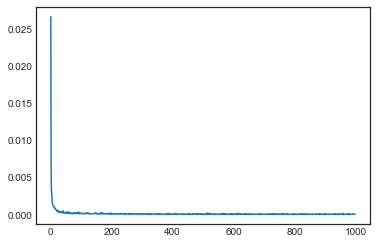

In [78]:
# Training the model
epochs_tot = 1000
epochs_step = 250
epochs_ratio = int(epochs_tot / epochs_step)
hist =np.array([])

for i in range(epochs_ratio):
    history = model.fit(features, targets, epochs=epochs_step, batch_size=100, verbose=0)
    
    # Evaluating the model on the training and testing set
    print("Step : " , i * epochs_step, "/", epochs_tot)
    score = model.evaluate(features, targets)
    print("Training MSE:", score[1])
    score = model.evaluate(features_validation, targets_validation)
    print("Validation MSE:", score[1], "\n")
    hist = np.concatenate((hist, np.array(history.history['mean_squared_error'])), axis = 0)
    
# plot metrics
plt.plot(hist)
plt.show()

In [79]:
y_pred = model.predict(features_validation, verbose=0)

print('R2 score = ',r2_score(y_test, y_pred), '/ 1.0')
print('MSE score = ',mean_squared_error(y_test, y_pred), '/ 0.0')

R2 score =  0.824665946811 / 1.0
MSE score =  0.00017478890525 / 0.0


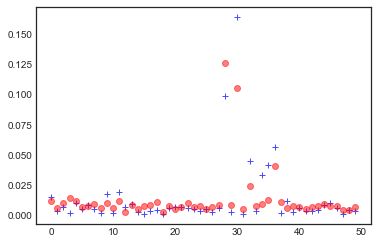

In [80]:
#Lets plot the  first 50 predictions
plt.plot(y_test.as_matrix()[0:50], '+', color ='blue', alpha=0.7)
plt.plot(y_pred[0:50], 'ro', color ='red', alpha=0.5)
plt.show()

In [81]:
df_train = pd.read_csv(
    'train.csv', usecols=[1, 2, 3, 4, 5],
    dtype={'onpromotion': bool},
    converters={'unit_sales': lambda u: np.log1p(
        float(u)) if float(u) > 0 else 0},
    parse_dates=["date"],
    skiprows=range(1, 66458909)  # 2016-01-01
)

In [82]:
df_train.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion
0,2016-01-01,25,105574,2.564949,False
1,2016-01-01,25,105575,2.302585,False
2,2016-01-01,25,105857,1.386294,False
3,2016-01-01,25,108634,1.386294,False
4,2016-01-01,25,108701,1.098612,True


In [83]:
df_train.shape

(59038132, 5)

In [84]:
df_train.tail()

,date,store_nbr,item_nbr,unit_sales,onpromotion
59038127,2017-08-15,54,2089339,1.609438,False
59038128,2017-08-15,54,2106464,0.693147,True
59038129,2017-08-15,54,2110456,5.262690,False
59038130,2017-08-15,54,2113914,5.293305,True
59038131,2017-08-15,54,2116416,1.098612,False


In [85]:
df_test = pd.read_csv(
    "test.csv", usecols=[0, 1, 2, 3, 4],
    dtype={'onpromotion': bool},
    parse_dates=["date"]  # , date_parser=parser
).set_index(
    ['store_nbr', 'item_nbr', 'date']
)

In [86]:
#we want to predict unit sales for last 15 days of Aug 2017
df_test.head()

id  onpromotion
store_nbr item_nbr date                              
1         96995    2017-08-16  125497040        False
          99197    2017-08-16  125497041        False
          103501   2017-08-16  125497042        False
          103520   2017-08-16  125497043        False
          103665   2017-08-16  125497044        False

In [87]:
items = pd.read_csv(
    "items.csv",
).set_index("item_nbr")

In [88]:
items.shape

(4100, 3)

In [89]:
df_2017 = df_train[df_train.date.isin(
    pd.date_range("2017-05-31", periods=7 * 11))].copy()
del df_train
#dates range from May 31st to 15th Aug~ 77 days

In [90]:
df_2017.shape

(8125670, 5)

In [91]:
df_2017.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion
50912462,2017-05-31,1,96995,0.693147,False
50912463,2017-05-31,1,99197,0.693147,False
50912464,2017-05-31,1,103520,1.386294,False
50912465,2017-05-31,1,103665,2.197225,False
50912466,2017-05-31,1,105574,1.386294,False


In [92]:
df_2017.isnull().sum()

date           0
store_nbr      0
item_nbr       0
unit_sales     0
onpromotion    0
dtype: int64

In [93]:
promo_2017_train = df_2017.set_index(
    ["store_nbr", "item_nbr", "date"])[["onpromotion"]].unstack(
        level=-1).fillna(False)
#pivots the table and we want last level of index which is date in our case

In [94]:
promo_2017_train.head()

onpromotion                                              \
date                2017-05-31 2017-06-01 2017-06-02 2017-06-03 2017-06-04   
store_nbr item_nbr                                                           
1         96995          False      False      False      False      False   
          99197          False      False      False      False      False   
          103520         False      False      False      False      False   
          103665         False      False      False      False      False   
          105574         False      False      False      False      False   

                                                                           \
date               2017-06-05 2017-06-06 2017-06-07 2017-06-08 2017-06-09   
store_nbr item_nbr                                                          
1         96995         False      False      False      False      False   
          99197         False      False      False      False      False   
          103520        False      False      False      False      False   
          103665        False      False      False      False      False   
          105574        False      False      False      False      False   

                      ...                                                  \
date                  ...     2017-08-06 2017-08-07 2017-08-08 2017-08-09   
store_nbr item_nbr    ...                                                   
1         96995       ...          False      False      False      False   
          99197       ...          False      False      False      False   
          103520      ...          False      False      False      False   
          103665      ...          False      False      False      False   
          105574      ...          False      False      False      False   

                                                                           \
date               2017-08-10 2017-08-11 2017-08-12 2017-08-13 2017-08-14   
store_nbr item_nbr                                                          
1         96995         False      False      False      False      False   
          99197         False      False      False      False      False   
          103520        False      False      False      False      False   
          103665        False      False      False      False      False   
          105574        False      False      False      False      False   

                               
date               2017-08-15  
store_nbr item_nbr             
1         96995         False  
          99197         False  
          103520        False  
          103665        False  
          105574        False  

[5 rows x 77 columns]

In [95]:
promo_2017_train.columns = promo_2017_train.columns.get_level_values(1)

In [96]:
promo_2017_train.columns

DatetimeIndex(['2017-05-31', '2017-06-01', '2017-06-02', '2017-06-03',
               '2017-06-04', '2017-06-05', '2017-06-06', '2017-06-07',
               '2017-06-08', '2017-06-09', '2017-06-10', '2017-06-11',
               '2017-06-12', '2017-06-13', '2017-06-14', '2017-06-15',
               '2017-06-16', '2017-06-17', '2017-06-18', '2017-06-19',
               '2017-06-20', '2017-06-21', '2017-06-22', '2017-06-23',
               '2017-06-24', '2017-06-25', '2017-06-26', '2017-06-27',
               '2017-06-28', '2017-06-29', '2017-06-30', '2017-07-01',
               '2017-07-02', '2017-07-03', '2017-07-04', '2017-07-05',
               '2017-07-06', '2017-07-07', '2017-07-08', '2017-07-09',
               '2017-07-10', '2017-07-11', '2017-07-12', '2017-07-13',
               '2017-07-14', '2017-07-15', '2017-07-16', '2017-07-17',
               '2017-07-18', '2017-07-19', '2017-07-20', '2017-07-21',
               '2017-07-22', '2017-07-23', '2017-07-24', '2017-07-25',
      

In [97]:
#Repeat same steps for test dataset
promo_2017_test = df_test[["onpromotion"]].unstack(level=-1).fillna(False)
promo_2017_test.columns = promo_2017_test.columns.get_level_values(1)

In [98]:
promo_2017_test.head()
promo_2017_test.shape

(210654, 16)

In [99]:
promo_2017_test = promo_2017_test.reindex(promo_2017_train.index).fillna(False)
#Reseting the index same as promo_2017_train
promo_2017 = pd.concat([promo_2017_train, promo_2017_test], axis=1)

In [100]:
del promo_2017_test,promo_2017_train

In [101]:
df_2017 = df_2017.set_index(
    ["store_nbr", "item_nbr", "date"])[["unit_sales"]].unstack(
        level=-1).fillna(0)
df_2017.columns = df_2017.columns.get_level_values(1)

In [102]:
promo_2017.head()

date                2017-05-31  2017-06-01  2017-06-02  2017-06-03  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False       False       False   

date                2017-06-04  2017-06-05  2017-06-06  2017-06-07  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False       False       False   

date                2017-06-08  2017-06-09     ...      2017-08-22  \
store_nbr item_nbr                             ...                   
1         96995          False       False     ...           False   
          99197          False       False     ...           False   
          103520         False       False     ...           False   
          103665         False       False     ...           False   
          105574         False       False     ...           False   

date                2017-08-23  2017-08-24  2017-08-25  2017-08-26  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False       False       False   

date                2017-08-27  2017-08-28  2017-08-29  2017-08-30  2017-08-31  
store_nbr item_nbr                                                              
1         96995          False       False       False       False       False  
          99197          False       False       False       False       False  
          103520         False       False       False       False       False  
          103665         False       False       False       False       False  
          105574         False       False       False       False       False  

[5 rows x 93 columns]

In [103]:
items = items.reindex(df_2017.index.get_level_values(1))

In [104]:
items.head()

,family,class,perishable
item_nbr,,,
96995,GROCERY I,1093,0
99197,GROCERY I,1067,0
103520,GROCERY I,1028,0
103665,BREAD/BAKERY,2712,1
105574,GROCERY I,1045,0


In [105]:
def get_timespan(df, dt, minus, periods):
    return df[
        pd.date_range(dt - timedelta(days=minus), periods=periods)
    ]

In [106]:
def prepare_dataset(t2017, is_train=True):
    X = pd.DataFrame({
        "mean_3_2017": get_timespan(df_2017, t2017, 3, 3).mean(axis=1).values,
        "mean_7_2017": get_timespan(df_2017, t2017, 7, 7).mean(axis=1).values,
        "mean_14_2017": get_timespan(df_2017, t2017, 14, 14).mean(axis=1).values,
        "promo_14_2017": get_timespan(promo_2017, t2017, 14, 14).sum(axis=1).values
    })
    for i in range(16):
        X["promo_{}".format(i)] = promo_2017[
            t2017 + timedelta(days=i)].values.astype(np.uint8)
    if is_train:
        y = df_2017[
            pd.date_range(t2017, periods=16)
        ].values
        return X, y
    return X

In [107]:
print("Preparing dataset...")
t2017 = date(2017, 6, 21)
X_l, y_l = [], []
for i in range(4):
    delta = timedelta(days=7 * i)
    X_tmp, y_tmp = prepare_dataset(
        t2017 + delta
    )
    X_l.append(X_tmp)
    y_l.append(y_tmp)
X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)
del X_l, y_l
X_val, y_val = prepare_dataset(date(2017, 7, 26))
X_test = prepare_dataset(date(2017, 8, 16), is_train=False)

Preparing dataset...


In [108]:
print("Training and predicting models...")
params = {
    'num_leaves': 2**5 - 1,
    'objective': 'regression_l2',
    'max_depth': 8,
    'min_data_in_leaf': 50,
    'learning_rate': 0.05,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 1,
    'metric': 'l2',
    'num_threads': 4
}


Training and predicting models...


In [109]:
MAX_ROUNDS = 1000
val_pred = []
test_pred = []
cate_vars = []

In [110]:
for i in range(16):
    print("=" * 50)
    print("Step %d" % (i+1))
    print("=" * 50)
    dtrain = lgb.Dataset(
        X_train, label=y_train[:, i],
        categorical_feature=cate_vars,
        weight=pd.concat([items["perishable"]] * 4) * 0.25 + 1
    )
    dval = lgb.Dataset(
        X_val, label=y_val[:, i], reference=dtrain,
        weight=items["perishable"] * 0.25 + 1,
        categorical_feature=cate_vars)
    bst = lgb.train(
        params, dtrain, num_boost_round=MAX_ROUNDS,
        valid_sets=[dtrain, dval], early_stopping_rounds=50, verbose_eval=50
    )
    print("\n".join(("%s: %.2f" % x) for x in sorted(
        zip(X_train.columns, bst.feature_importance("gain")),
        key=lambda x: x[1], reverse=True
    )))
    val_pred.append(bst.predict(
        X_val, num_iteration=bst.best_iteration or MAX_ROUNDS))
    test_pred.append(bst.predict(
        X_test, num_iteration=bst.best_iteration or MAX_ROUNDS))

Step 1


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 0.345097	valid_1's l2: 0.341325
[100]	training's l2: 0.333329	valid_1's l2: 0.330014
[150]	training's l2: 0.331387	valid_1's l2: 0.328774
[200]	training's l2: 0.330338	valid_1's l2: 0.328296
[250]	training's l2: 0.329482	valid_1's l2: 0.327889
[300]	training's l2: 0.328796	valid_1's l2: 0.327648
[350]	training's l2: 0.328179	valid_1's l2: 0.327391
[400]	training's l2: 0.32762	valid_1's l2: 0.32721
[450]	training's l2: 0.327135	valid_1's l2: 0.327108
[500]	training's l2: 0.326678	valid_1's l2: 0.327039
[550]	training's l2: 0.326257	valid_1's l2: 0.326976
[600]	training's l2: 0.325865	valid_1's l2: 0.32694
[650]	training's l2: 0.325471	valid_1's l2: 0.32692
[700]	training's l2: 0.325077	valid_1's l2: 0.326862
[750]	training's l2: 0.32472	valid_1's l2: 0.326886
Early stopping, best iteration is:
[700]	training's l2: 0.325077	valid_1's l2: 0.326862
mean_14_2017: 1986449.84
mean_7_2017: 1457763.98
mean_3_2017:

[100]	training's l2: 0.387503	valid_1's l2: 0.484477
[150]	training's l2: 0.38451	valid_1's l2: 0.483293
Early stopping, best iteration is:
[133]	training's l2: 0.385266	valid_1's l2: 0.483197
mean_14_2017: 2173915.37
mean_7_2017: 779085.54
mean_3_2017: 309418.75
promo_6: 153438.12
promo_14_2017: 48445.64
promo_3: 14017.86
promo_7: 9137.57
promo_13: 8640.51
promo_5: 7108.16
promo_0: 4701.30
promo_1: 3898.41
promo_4: 3646.02
promo_9: 3257.32
promo_2: 2908.48
promo_14: 2786.73
promo_8: 1924.80
promo_15: 943.23
promo_12: 873.16
promo_11: 850.42
promo_10: 779.03
Step 8
Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 0.38804	valid_1's l2: 0.460395
[100]	training's l2: 0.375671	valid_1's l2: 0.44255
[150]	training's l2: 0.372894	valid_1's l2: 0.439745
[200]	training's l2: 0.371495	valid_1's l2: 0.438764
[250]	training's l2: 0.370359	valid_1's l2: 0.438271
[300]	training's l2: 0.369416	valid_1's l2: 0.437744
[350]	training's l2: 0.368715	valid_1's l2: 0.43761

Step 15
Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 0.410919	valid_1's l2: 0.410371
[100]	training's l2: 0.397115	valid_1's l2: 0.398748
[150]	training's l2: 0.394313	valid_1's l2: 0.397684
[200]	training's l2: 0.392711	valid_1's l2: 0.397309
[250]	training's l2: 0.391556	valid_1's l2: 0.397216
[300]	training's l2: 0.390632	valid_1's l2: 0.397001
[350]	training's l2: 0.389878	valid_1's l2: 0.396751
[400]	training's l2: 0.389201	valid_1's l2: 0.396668
[450]	training's l2: 0.388549	valid_1's l2: 0.396577
Early stopping, best iteration is:
[443]	training's l2: 0.388637	valid_1's l2: 0.396544
mean_14_2017: 2325703.66
mean_7_2017: 697625.27
mean_3_2017: 244009.25
promo_14: 232375.05
promo_14_2017: 50039.63
promo_7: 32257.52
promo_0: 29105.04
promo_15: 20072.46
promo_13: 11033.72
promo_9: 9036.77
promo_12: 8426.44
promo_10: 6103.29
promo_2: 4641.07
promo_6: 4357.55
promo_11: 3179.79
promo_8: 2955.70
promo_4: 2468.38
promo_1: 1808.81
promo_5: 1281.50
prom

In [111]:
print("Validation mse:", mean_squared_error(
    y_val, np.array(val_pred).transpose()))

Validation mse: 0.413994342653


In [112]:
print("Making submission...")
y_test = np.array(test_pred).transpose()
df_preds = pd.DataFrame(
    y_test, index=df_2017.index,
    columns=pd.date_range("2017-08-16", periods=16)
).stack().to_frame("unit_sales")
df_preds.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)


Making submission...


In [ ]:
submission = df_test[["id"]].join(df_preds, how="left").fillna(0)

In [ ]:
submission["unit_sales"] = np.clip(np.expm1(submission["unit_sales"]), 0, 1000)
submission.to_csv('lgb.csv', float_format='%.4f', index=None)